## DATASET PREPROCESSING
Il preprocessing che effettuo è solamente un riordinamento delle immagini, prendendole dal dataset e unendole tutte in altre directory

### Import e inizializzazioni

In [1]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
import os
import shutil
from PIL import Image
import cv2
import skimage
import pydicom
import scipy
import numpy as np
import math
from matplotlib import pyplot as plt
from glob import glob

# struttura INIZIALE: non contiene la divisione in classi. Vedere markdown successivo per speigazioni
dir_structure = {
    "./Preprocessed_Set/":
    {
        "T1DUAL": 
        {
            "InPhase": 
            {
                "Images": {}, 
                "Masks" : {}
            },
            "OutPhase":
            {
                "Images": {}, 
                "Masks" : {}
            } 
            
        },
        "T2SPIR":
        {
            "Images": {}, 
            "Masks" : {}
        } 
    }
}

In [2]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
# utils functions
"""
Trova ogni possibile directory dell'albero di directory specificato
L'albero è espresso come un dizionario fatto da dizionari nestati, dove ogni dizionario 
rappresenta la directory e ha come chiavi i nomi delle sottodirectory, i cui valori sono 
a loro volta dizionari
"""
def get_paths(directory_tree):
    def _get_paths(directory_tree):

        paths = ["", ]
        for dir, subdir in directory_tree.items():
            current_path = dir
            ret_paths = _get_paths(subdir)
            for ret_path in ret_paths:
                paths.append(os.path.join(dir, ret_path))
        
        return paths
    
    result = _get_paths(directory_tree)
    result.remove('')    

    return result

def find_path(directory_tree, dir_name):
    result = []
    for cur_dir in directory_tree.keys():
        if cur_dir == dir_name:
            result.append(cur_dir)
            
        for found_dir in find_path(directory_tree[cur_dir], dir_name):
            result.append(os.path.join(cur_dir,found_dir))
    
    return result
        

### Creazione directories
Creo una directory per ogni protocollo, perchè elaborerò solo un protocollo alla volta, avendo dei valori troppo diversi tra loro.  
Future implementazioni potrebbero elaborare più protocolli alla volta, in tal caso sarà necessario modificare la struttura del dataset.  
  
Struttura delle directory:  
Preprocessed_set_2    
|-> T1DUAL  
----|-> InPhase  
--------|-> Images  
--------|-> Masks  
------------|-> Classei (con i=1,..,5)  
----|-> OutPhase  
--------|-> Images  
--------|-> Masks  
------------|-> Classei (con i=1,..,5)  
|-> T2SPIR  
----|-> Images  
----|-> Masks  
--------|-> Classei (con i=1,..,5)  

Inizialmente non considero le classi, poi, in uno dei punti successivi, divido in classi le immagini

In [26]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
"""
Costruisce un directory_tree sotto forma di dizionari fatto da dizionari nestati.
# """


def build_directory_tree(path):
    def _build_directory_tree(path):
        cur_dir = dict()
        _, subdirs, _ = os.walk(path).__next__()
        for subdir in subdirs:
            cur_dir[subdir] = _build_directory_tree(os.path.join(path,subdir))

        return cur_dir

    result = dict()
    result[os.path.basename(path)] = _build_directory_tree(path)

    return result

In [27]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
# costruzione della directory
for path in get_paths(dir_structure):
    os.mkdir(path)

In [28]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
chaos_directory_tree = build_directory_tree("./CHAOS_Train_Sets")
chaos_directory_tree["CHAOS_Train_Sets"]["Train_Sets"].pop("CT")
print(get_paths(chaos_directory_tree))

['CHAOS_Train_Sets/', 'CHAOS_Train_Sets/Train_Sets/', 'CHAOS_Train_Sets/Train_Sets/MR/', 'CHAOS_Train_Sets/Train_Sets/MR/1/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/InPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/DICOM_anon/OutPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/1/T2SPIR/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/10/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/InPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/DICOM_anon/OutPhase/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T1DUAL/Ground/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T2SPIR/', 'CHAOS_Train_Sets/Train_Sets/MR/10/T2SPIR/DICOM_anon/', 'CHAOS_Train_Sets/Train_Se

### Trasferimento files nella directory

In [29]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
prep_t1dual_path = "./Preprocessed_Set/T1DUAL"
prep_t2spir_path = "./Preprocessed_Set/T2SPIR"
chaos_paths = get_paths(chaos_directory_tree)

for index, path in enumerate(chaos_paths):
    # ho strutture di directory diverse tra T1DUAL e T2SPIR, quindi non posso farli insieme
    if ( os.path.basename(path[:-1]) == "T1DUAL"):
        inphase_path = chaos_paths[index+2]
        outphase_path = chaos_paths[index+3]
        ground_path = chaos_paths[index+4]

        # per ogni fase copio le rispettive immagini nelle rispettive cartelle
        for phase_path in [inphase_path, outphase_path]:
            _,_,filenames = os.walk(phase_path).__next__()
            for filename in filenames:
                src_path = os.path.join(phase_path, filename)
                dst_path = os.path.join(prep_t1dual_path, os.path.basename(phase_path[:-1]), "Images",filename)
                shutil.copy(src_path, dst_path)

        # infine copio i ground truth
        _,_, filenames = os.walk(ground_path).__next__()
        for filename in filenames:
            src_path = os.path.join(ground_path, filename)
            dst_path1 = os.path.join(prep_t1dual_path, "InPhase/Masks",filename)
            dst_path2 = os.path.join(prep_t1dual_path, "OutPhase/Masks",filename)

            shutil.copy(src_path, dst_path1)
            shutil.copy(src_path, dst_path2)

    
    
    elif ( os.path.basename(path[:-1]) == "T2SPIR"):
        images_path = chaos_paths[index+1]
        ground_path = chaos_paths[index+2]
        # copio immagini
        _,_,filenames = os.walk(images_path).__next__()
        for filename in filenames:
            src_path = os.path.join(images_path, filename)
            dst_path = os.path.join(prep_t2spir_path, "Images",filename)
            shutil.copy(src_path, dst_path)

        # copio maschere
        _,_,filenames = os.walk(ground_path).__next__()
        for filename in filenames:
            src_path = os.path.join(ground_path, filename)
            dst_path = os.path.join(prep_t2spir_path, "Masks",filename)
            shutil.copy(src_path, dst_path)



### Rinomina files

In [ ]:
# qui eventuale rinomina dei files

### Conversione immagini in png
Da fare solo se non si fa il ridimensionamento

In [30]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,image_names = os.walk(images_path).__next__()
    for image_name in image_names:
        image_path = os.path.join(images_path, image_name)
        image = np.array(pydicom.dcmread(image_path).pixel_array)
        Image.fromarray(image).save(image_path.replace(".dcm", ".png"))


### Ridimensionamento immagini e maschere
Siccome alcune immagini e maschere hanno dimensione diversa da 256x256, le uniformo a tale misura.  
Se ridimensiono le immagini (da $288^2$ a $256^2$) in modo non attento, modifico i pixel delle maschere e rischio di portarli dal range di un organo a quello di un altro. Devo evitare questa cosa.  
Possibili soluzioni:
* divido il range 0-255 in classi continue
    * problema: se interpolo tra right kidney e background, tra i 2 "genero" dei pixel del range del liver ma non ha senso
* il ridimensionamento dell'immagine avviene con ordine di interpolazione qualsiasi MA quello della maschera con ordine di interpolazione = 0 -> mantengo i valori già esistenti
  
Ho scelto per questo motivo di ridimensionare sia immagine sia maschera con ordine = 0 (costante)  

In [70]:
images_paths = find_path(dir_structure, "Images")

for images_path in images_paths:
    masks_path = os.path.join(os.path.split(images_path)[0], "Masks")
    
    _,_,image_names = os.walk(images_path).__next__()
    _,_,mask_names = os.walk(masks_path).__next__()

    for index, image_name in enumerate(image_names):
        image_path = os.path.join(images_path, image_name)
        mask_path = os.path.join(masks_path, mask_names[index])

        image = pydicom.dcmread(image_path)
        mask = Image.open(mask_path)

        # reshape di immagine e maschera
        if ( image.pixel_array.shape != (256,256)):
            os.remove(image_path)
            os.remove(mask_path)
            image = np.array(image.pixel_array)
            mask = np.array(mask)
            target_shape = (
                256/image.shape[0],
                256/image.shape[1]
            )
            reshaped_image = scipy.ndimage.zoom(image, target_shape, order=0, mode="nearest")    
            reshaped_mask = scipy.ndimage.zoom(mask, target_shape, order=0, mode="nearest")    
        else:
            reshaped_image = np.array(image.pixel_array)
            reshaped_mask = np.array(mask)
        Image.fromarray(reshaped_image).save(image_path.replace(".dcm", ".png"))
        Image.fromarray(reshaped_mask).save(mask_path)


# IN CHE FILE SALVO L'IMMAGINE? non dcm PERCHè HA UN HEADER => PNG (semplicemente ho salvato l'array in un file)

In [18]:
# qui se voglio fare reshape solo delle maschere

masks_paths = find_path(dir_structure, "Masks")
for masks_path in masks_paths:

    _,_,mask_names = os.walk(masks_path).__next__()
    for index, mask_name in enumerate(mask_names):
        mask_path = os.path.join(masks_path, mask_names[index])

        mask = np.array(Image.open(mask_path))

        # reshape di immagine e maschera
        if ( mask.shape != (256,256)):
            os.remove(mask_path)
            target_shape = (
                256/mask.shape[0],
                256/mask.shape[1]
            )
            reshaped_mask = scipy.ndimage.zoom(mask, target_shape, order=3, mode="nearest")    

            Image.fromarray(reshaped_mask).save(mask_path)


In [31]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
# rimozione immagini dcm
images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,filenames = os.walk(images_path).__next__()
    for filename in filenames:
        image_path = os.path.join(images_path,filename)
        if filename.endswith(".dcm"):
            os.remove(image_path)



### Standardizzazione intensità immagini
Le immagini hanno intensità diverse, quindi è bene normalizzarle (ad esempio al range[0,1]).   
Così non ci saranno immagini che portano ad attivazioni eccessivamente più grandi di altre immagini.  

Dal codice qui sotto si vede come le immagini abbiano valori molto diversi tra loro, quindi è necessaria una standardizzazione/normalizzazione.  

In [4]:
values = []
images_paths = find_path(dir_structure, "Images")
images_path = images_paths[1]
_,_,filenames = os.walk(images_path).__next__()
for filename in filenames:
    image_path = os.path.join(images_path,filename)
    image = np.array(Image.open(image_path))
    cur_max = 0
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y][x] > cur_max: cur_max = image[y][x]
    
    values.append(cur_max)

print(min(values), max(values))

# non ho calcolato quale è il valore minimo di ogni classe perchè è molto probabilmente 0
                

289 1344


domanda: perchè le immagini appaiono così diverse? Secondo me non è tanto dovuto al passaggio a png ma, avendo interpolato per cambiare le dimensioni, matplotlib me lo vede in modo diverso

Idealmente opto per la standardizzazione perchè è più semplice della normalizzazione.  
Inoltre la normalizzazione, se non eseguita bene (cioè prendendo un "quantile" meno estremo del massimo/minimo), rischia di comprimere troppo i valori delle immagini.  
Tuttavia la standardizzazione mi richiede di rappresentare i dati come float ma non posso farlo nelle immagini PNG.  
Inoltre non mi riporta tutto alla scala \[0,1], quindi non posso nemmeno moltiplicarlo per 256
Una possibile soluzione da sperimentare è standardizzare e moltiplicare. Quando standardizzo hanno tutti lo stesso "spread", poi moltiplicando porto a valori rappresentabili dal png.  
  
Decido quindi di **normalizzare a \[0-255] tutto il dataset**

In [32]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
# normalizzo al range 0-255 ogni immagine

images_paths = find_path(dir_structure, "Images")
for images_path in images_paths:
    _,_,filenames = os.walk(images_path).__next__()
    for filename in filenames:
        image_path = os.path.join(images_path,filename)
        image = np.array(Image.open(image_path))

        """
        sum = 0
        squared_sum = 0
        flat = image.flatten()
        for pixel in flat:
            sum += pixel
            squared_sum += pixel**2
        
        mean = sum/len(flat)
        deviation = squared_sum/len(flat) - mean**2
        std_dev = math.sqrt(deviation)
        """
        max_val, min_val = max(image.flatten()), min(image.flatten())

        for y in range(image.shape[0]):
            for x in range(image.shape[1]):
                image[y][x] = (float(image[y][x] - min_val))/(max_val-min_val) * 255
        
        Image.fromarray(image).save(image_path)
        


### Correzione nomi delle immagini OutPhase
Hanno nomi diversi dalle maschere ($LastDigitOut = LastDigitMask - 1$).  

In [33]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
outphase_path = find_path(dir_structure, "OutPhase")[0]
images_path = os.path.join(outphase_path, "Images")
masks_path = os.path.join(outphase_path, "Masks")

_,_, image_names = os.walk(images_path).__next__()
_,_, mask_names = os.walk(masks_path).__next__()

for i in range(len(image_names)):
    old_image_path = os.path.join(images_path, image_names[i])
    new_image_path = os.path.join(images_path, mask_names[i])
    mask_path = os.path.join(masks_path, mask_names[i])
    
    shutil.move(old_image_path, new_image_path)

### Preparazione maschere per one hot encoding
Riporto tutte le classi al range 0-4 (4 incluso)

In [34]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
mapping = dict([(0,0),(63,1),(126,2),(189,3),(252,4)])
uniques = set()
mask_paths = glob("./Preprocessed_Set/*/*/Masks/*png") + glob("./Preprocessed_Set/*/Masks/*png")
for mask_path in mask_paths:
    mask = np.array(Image.open(mask_path))
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            mask[i][j] = mapping[mask[i][j]]
    Image.fromarray(mask).save(mask_path)


### Aggiunta maschera per "non target" body
Voglio separare il background effettivo (nero) dal corpo del paziente

In [9]:
# STEP ESEGUITO PRIMA DEL PREPROCESSING DI TENSORFLOW
image_paths = sorted(glob("./Preprocessed_Set/*/*/Images/*png") + glob("./Preprocessed_Set/*/Images/*png"))
mask_paths = sorted(glob("./Preprocessed_Set/*/*/Masks/*png") + glob("./Preprocessed_Set/*/Masks/*png"))

treshold = 10
for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    if (os.path.basename(image_path) != os.path.basename(mask_path)):
        print("warning: unpaired image-path found:", image_path, mask_path)
        continue

    image = Image.open(image_path)
    img = np.array(Image.open(image_path))
    msk = np.array(Image.open(mask_path))


    new_msk = np.zeros(msk.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #new_msk[i][j] = 0 if (msk[i][j] == 0 and img[i][j] < treshold) else msk[i][j]+1
            if (msk[i][j] == 0 and img[i][j] < treshold): new_msk[i][j] = 0
            else: new_msk[i][j] = msk[i][j] + 1

    Image.fromarray(new_msk).save(mask_path)
            

### Divisione maschera in 5 classi
Divido ora i folder "Masks" in 5 subfolders: uno per classe (background, liver, left kidney, right kidney, spleen).  
Siccome l'interpolazione mi modifica i valori delle immagini, il rischio è che esca fuori dai range indicati nel file [readme](./CHAOS_Train_Sets/Train_Sets/NOTES_PLEASE_READ.txt).  
Modifico quindi i ranges in modo da **coprire tutti i 256 valori di grigio**, così non ho incertezza su che classe appartiene il pixel.  
Valori:  
(Background: 0                  -> (0-27))  
Liver: 63 (55<<<70)             -> (28-80)  
Right kidney: 126 (110<<<135)   -> (81-155)  
Left kidney: 189 (175<<<200)    -> (156-220)  
Spleen: 252 (240<<<255)         -> (221-255)  
Ciò non è necessario visto che l'interpolazione usata per il ridimensionamento della maschera è _costante_, e quindi "non crea altri valori di pixels ma semplicemente copia e incolla quelli già presenti".  
In ogni caso è un livello di sicurezza maggiore che non porta a inefficienze.  

In [5]:
mask_classes = ["Background", "Liver", "Right kidney", "Left kidney", "Spleen"]
mask_ranges = [[0,27],[28,80],[81,155],[156,220],[221,255]]
mask_values = [0, 63, 126, 189, 252]
mask_map = [-1]*256     # ad ogni valore di pixel assegno il numero di classe (0-4)
for index, rnge in enumerate(mask_ranges):  
    for i in range(rnge[0],rnge[1]+1):
        mask_map[i] = index

current_masks_paths = find_path(dir_structure, "Masks")

In [6]:
# creazione classi
for current_masks_path in current_masks_paths:
    for mask_class in mask_classes:
        os.mkdir(os.path.join(current_masks_path, mask_class))

In [7]:
# suddivisione di ogni maschera nelle classi
for current_masks_path in current_masks_paths:
    _,_,mask_names = os.walk(current_masks_path).__next__()
    for mask_name in mask_names:
        mask_path = os.path.join(current_masks_path, mask_name)

        mask = np.array(Image.open(mask_path))
        final_masks = []

        for mask_class in mask_classes:
            final_mask = np.zeros(mask.shape)
            final_masks.append(final_mask)

        for y in range(mask.shape[0]):
            for x in range(mask.shape[1]):
                final_masks[mask_map[mask[y,x]]][y,x] = 255  # mappo ogni pixel alla rispettiva maschera

        for index, mask_class in enumerate(mask_classes):
            base_path, cur_mask = os.path.split(mask_path)
            final_mask_path = os.path.join(base_path,mask_class, cur_mask)
            Image.fromarray(final_masks[index].astype(np.uint8)).save(final_mask_path)


In [80]:
# test per verificare se ci sono pixel out of range (e ci sono)
mask_pil = Image.open("./Preprocessed_Set/T1DUAL/InPhase/Masks/Liver/IMG-0010-00026.png")
mask = np.array(mask_pil)
histogram = mask_pil.histogram()
#print([(index,bin) for (index,bin) in enumerate(histogram)])
out_of_range = []
for index, bin in enumerate(histogram):
    if mask_map[index] == -1 and bin > 0:
        out_of_range.append((index,bin))

print(out_of_range)

[]


In [78]:
# rimozione maschere intere
for current_masks_path in current_masks_paths:
    _,_,mask_names = os.walk(current_masks_path).__next__()
    for mask_name in mask_names:
        mask_path = os.path.join(current_masks_path, mask_name)
        os.remove(mask_path)


Il codice sottostante compara le immagini ottenute con ridimensionamento tramite interpolazione (polinomiale) costante e quella (polinomiale) di 3° grado.  
Le differenze visive sono impercettibili, tuttavia è matematicamente più corretta (nel mio caso) la prima perchè **interpola solo con 1 pixels, copiandolo** e non 3. Quindi mi permette di **essere certo su che classe appartiene tale pixel**

In [ ]:
img = np.array(pydicom.dcmread("./b.dcm").pixel_array)
msk = np.array(Image.open("./b.png"))

plt.figure(figsize=(15,8))


target_shape = (256/288, 256/288)
img2 = scipy.ndimage.zoom(img, target_shape, order=0, mode="nearest")
msk2 = scipy.ndimage.zoom(msk, target_shape, order=0, mode="nearest")
img3 = scipy.ndimage.zoom(img, target_shape, order=3, mode="nearest")
msk3 = scipy.ndimage.zoom(msk, target_shape, order=3, mode="nearest")

plt.subplot(2,3,1)
plt.imshow(img, cmap="gray")
plt.subplot(2,3,2)
plt.imshow(img2, cmap="gray")
plt.subplot(2,3,3)
plt.imshow(img3, cmap="gray")

plt.subplot(2,3,4)
plt.imshow(msk,cmap="gray")
plt.subplot(2,3,5)
plt.imshow(msk2,cmap="gray")
plt.subplot(2,3,6)
plt.imshow(msk3,cmap="gray")


IMG-0004-00002.png


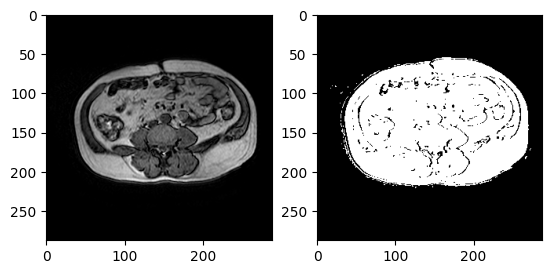

IMG-0004-00004.png


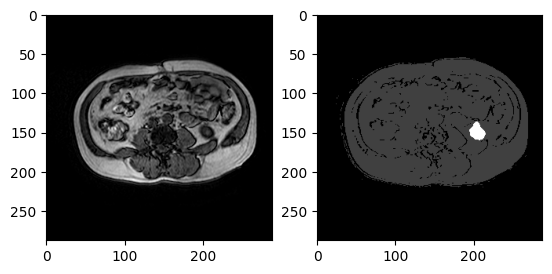

KeyboardInterrupt: Interrupted by user

In [7]:
imgs = sorted(glob("./Preprocessed_Set/T1DUAL/OutPhase/Images/*png"))
msks = sorted(glob("./Preprocessed_Set/T1DUAL/OutPhase/Masks/*png"))

for (img_path, msk_path) in zip(imgs,msks):
    img = np.array(Image.open(img_path))
    msk = np.array(Image.open(msk_path))
    print(os.path.basename(img_path))
    plt.close()
    plt.subplot(1,2,1)
    plt.imshow(img, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(msk, cmap="gray")
    plt.show()

    input("")

./Preprocessed_Set/T1DUAL/InPhase/Masks/IMG-0004-00002.png
[0 2]


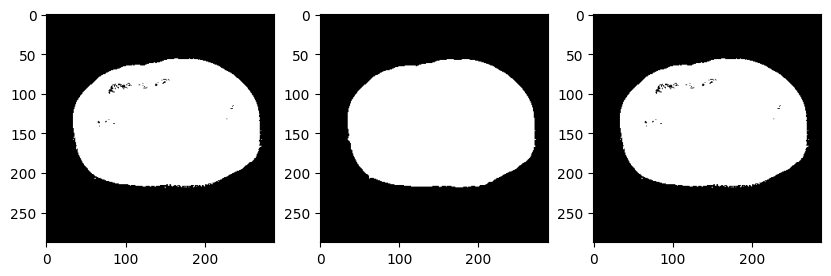

In [8]:
msks = sorted(glob("./Preprocessed_Set/T1DUAL/*/Masks/*.png")) + sorted(glob("./Preprocessed_Set/T2SPIR/Masks/*.png"))
counter = 0
for msk_path in msks:
    msk = np.array(Image.open(msk_path))

    body_msk = np.zeros(msk.shape, dtype=msk.dtype)
    for i in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            body_msk[i][j] = 0 if msk[i][j] == 0 else 1

    new_body_msk = cv2.morphologyEx(body_msk, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6,6)))
    new_msk = np.zeros(msk.shape, dtype=msk.dtype)

    for i in range(msk.shape[0]):
        for j in range(msk.shape[1]):
            new_msk[i][j] = msk[i][j] if msk[i][j] == 2 else 0

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.imshow(msk, cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(new_body_msk, cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(new_msk, cmap="gray")
    break
    #if counter >= 5: break
    #counter += 1
    #Image.fromarray(new_msk).save(msk_path)


In [6]:
msk_path = "./CHAOS_Train_Sets/Train_Sets/MR/1/T1DUAL/Ground/IMG-0004-00002.png"
msk = np.array(Image.open(msk_path))
print(np.unique(msk))

[0]


# ATTENZIONE LA MASCHERA IMG-0004-00002.png HA CLASSI 0 e 2 QUANDO DOVREBBE AVERE 0 e 1